In [148]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from hierarchy_pos import hierarchy_pos
import matplotlib.patches as mpatches

## Generating data

In [149]:
no_signals = 100
X = np.linspace(1,1000,1000)
unused = [(0,200), (450,520), (550, 580), (700,850), (940,1000)]
ideal_signal = np.ones(X.shape) * 20
for start,stop in unused:
    ideal_signal[start:stop] = -50

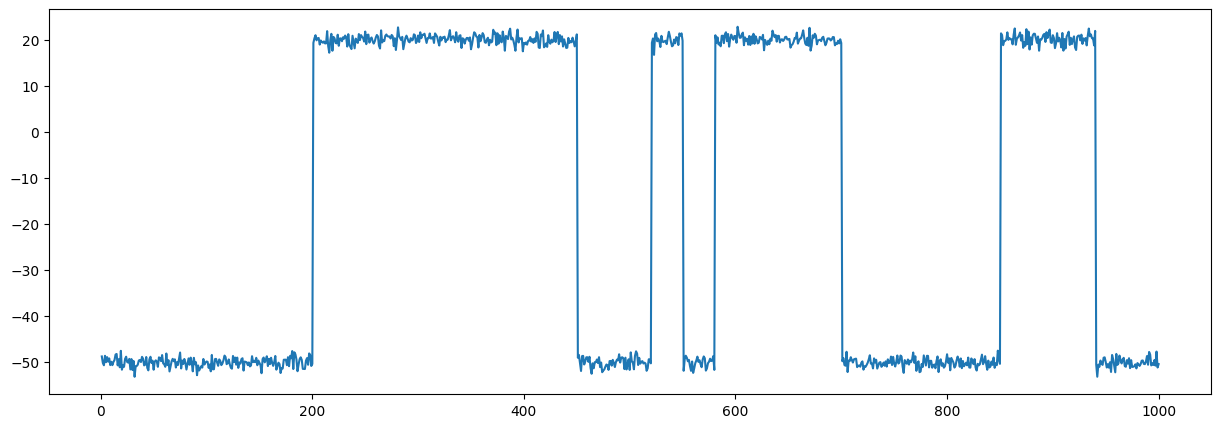

In [150]:
rnd = np.random.default_rng(seed=833142)
noise = rnd.normal(0, 1, size=(no_signals,1000))
signals = noise + ideal_signal
fig = plt.figure(figsize=(15,5))
ax =fig.subplots()
ax.plot(X, signals[0,])
plt.show()

In [151]:
graph = nx.DiGraph()
no_clusters = 12
clusters = np.arange(no_clusters)
cluster_assignments = rnd.choice(clusters, 100, replace=True)
cluster_set  = set(clusters)
i = no_clusters
while len(cluster_set) > 1:
    c1, c2 = rnd.choice(list(cluster_set), 2, replace=False)
    cluster_set.discard(c1)
    cluster_set.discard(c2)
    cluster_set.add(i)
    graph.add_edges_from([(i, c1), (i, c2)])
    i += 1


In [152]:
impairments = {
    "Suckout" : (20, "green", np.arange(300,370), 0.5 * (np.abs(np.arange(-35, 35)) - 35)),
    "Wave" : (12, "orange", np.arange(580,700), 3*np.sin(np.arange(120)/5)),
}

tilt_x = np.arange(1000)
tilt_y = np.zeros(1000,)
tilt_y[ideal_signal > 0] = -tilt_x[ideal_signal > 0] * 0.02
impairments["Tilt"] = (19, "red", tilt_x, tilt_y)

nx.set_node_attributes(graph, "blue", "color")
attrs = {id: {"color": color} for id, color, _, _ in impairments.values()}
nx.set_node_attributes(graph, attrs)

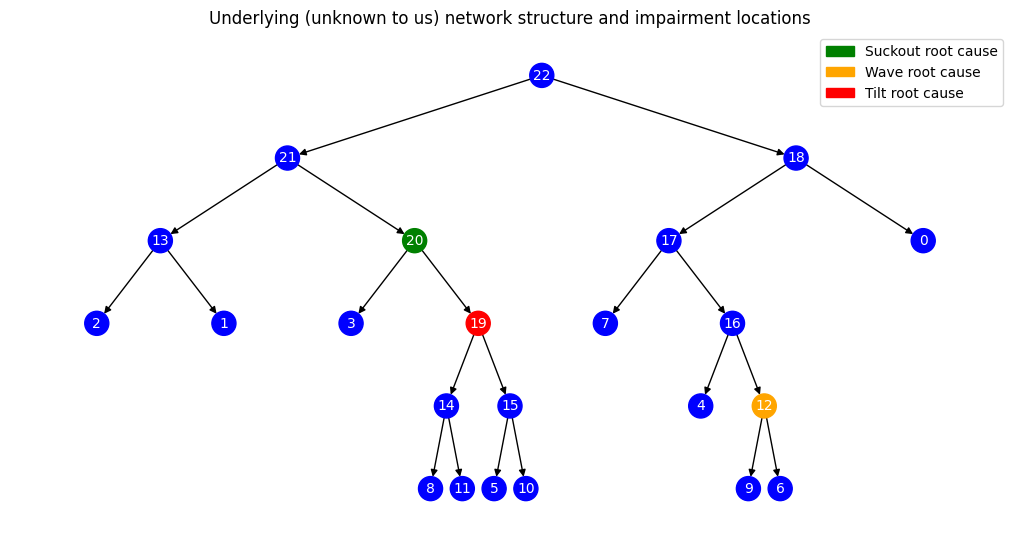

In [153]:
pos = hierarchy_pos(graph,no_clusters * 2 - 2)    
handles=[mpatches.Patch(color=color, label=f"{name} root cause") for name, (_, color, _, _) in impairments.items()]
fig = plt.figure(figsize=(10,5))
colors = list(nx.get_node_attributes(graph,'color').values())
nx.draw(graph, pos = pos, with_labels=True, node_color = colors, font_size=10, font_color="white")
plt.legend(handles=handles)
plt.title("Underlying (unknown to us) network structure and impairment locations")
plt.show()

In [154]:
imp_signals = signals.copy()
for imp_name, (edge, _, imp_x, imp_y) in impairments.items():
    affected_children = [y for x,y in nx.edge_dfs(graph, edge)]
    affected_clusters = [x for x in affected_children + [edge] if x < no_clusters]
    for cluster in affected_clusters:
        rel_signals = imp_signals[cluster_assignments == cluster,:]
        rel_signals[:,imp_x] += imp_y
        imp_signals[cluster_assignments == cluster,:] = rel_signals
    
    

In [155]:
samples = {
    'Healthy signal': imp_signals[cluster_assignments == 2,:][0],
    'Suckout impaired signal': imp_signals[cluster_assignments == 3,:][0],
    'Tilt-suckout impaired signal': imp_signals[cluster_assignments == 8,:][0],
    'Wave impaired signal': imp_signals[cluster_assignments == 9,:][0],
}

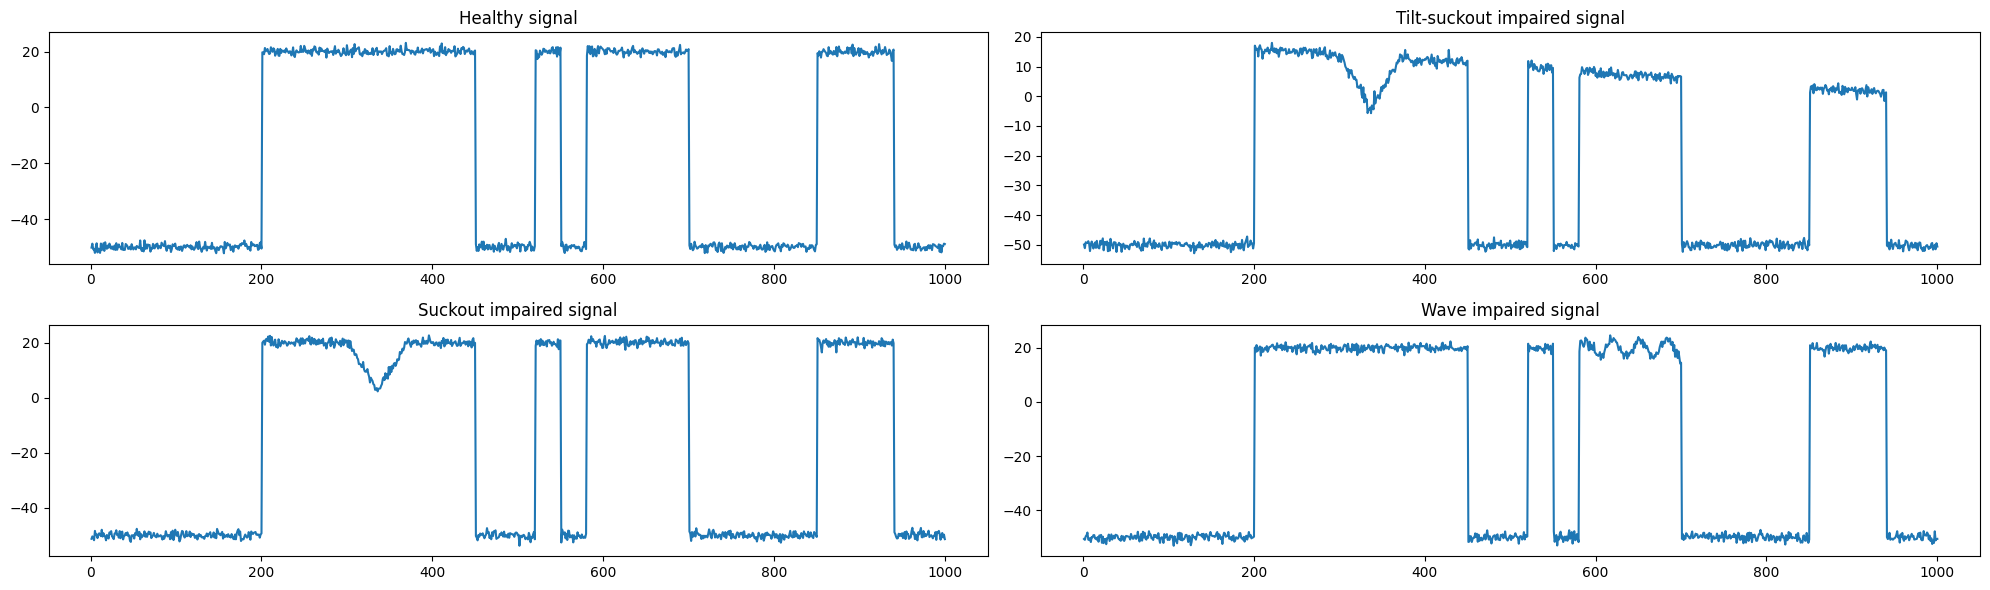

In [156]:
fig = plt.figure(figsize=(20,6))
ax =fig.subplots(2,2)
for i, (title, signal) in enumerate(samples.items()):
    row = i % 2
    col = int(i / 2)
    ax[row, col].plot(X, signal)
    ax[row, col].set_title(title)
plt.tight_layout()
plt.show()


## Obtaining wavelet coefficients and performing clustering

In [157]:
from sklearn.metrics import pairwise_distances
import pywt
from scipy.sparse import csr_matrix
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


In [158]:
coeffs = pywt.wavedec(imp_signals, "db1", mode='zero', level=7, axis=1) #list of 7 x [100 x #no_coeffs]
unraveled = coeffs[0]
for level in coeffs[1:]:
    unraveled = np.concatenate([unraveled, level], axis=1)

unraveled[np.abs(unraveled) < 30] = 0 #threshold at a hardcoded value of 30 (chosen based on experience)
sparse_matrix = csr_matrix(unraveled)
print(f"Number of non_zero entries: {sparse_matrix.count_nonzero()}")

Number of non_zero entries: 4637


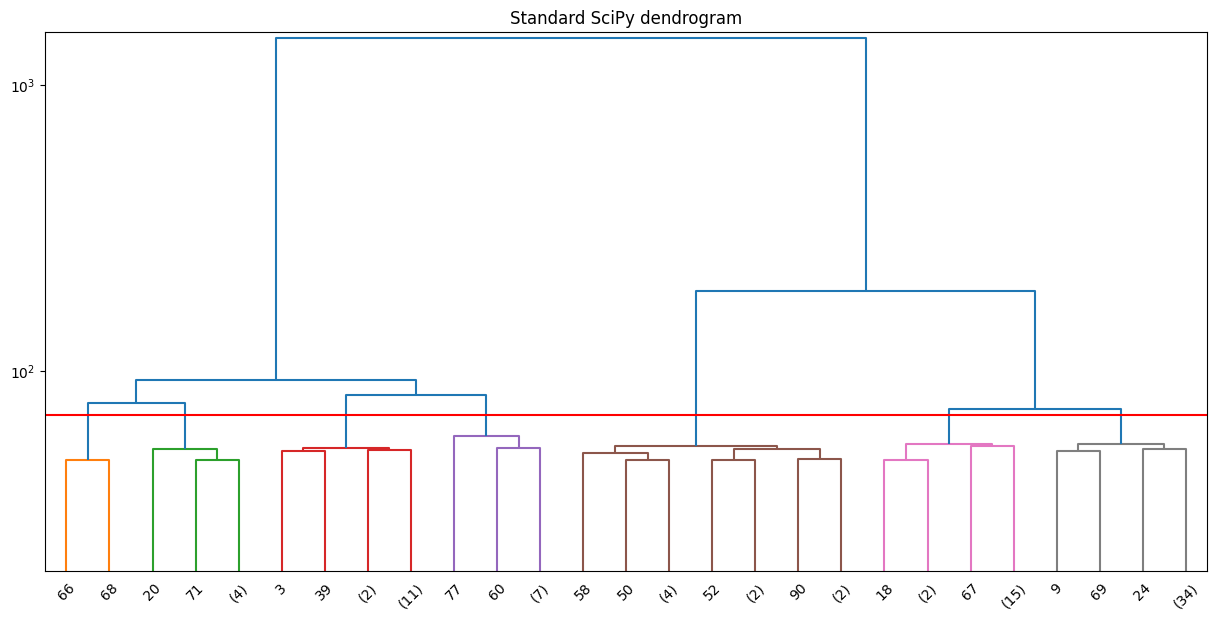

In [159]:
pdists = pairwise_distances(sparse_matrix, metric='cityblock')            
dists = squareform(pdists)   
model = sch.linkage(dists, method='average')
threshold = 70
figure = plt.figure(figsize=(15,7))
ax = figure.subplots()
sch.dendrogram(model, ax=ax, truncate_mode='level', p=4, color_threshold=threshold)
plt.yscale('symlog')
plt.ylim(20)
plt.axhline(threshold, color='red')
plt.title("Standard SciPy dendrogram")
plt.show()

In [160]:
recovered_clusters = sch.fcluster(model, threshold, criterion='distance')
recovered_clusterset = set(recovered_clusters)

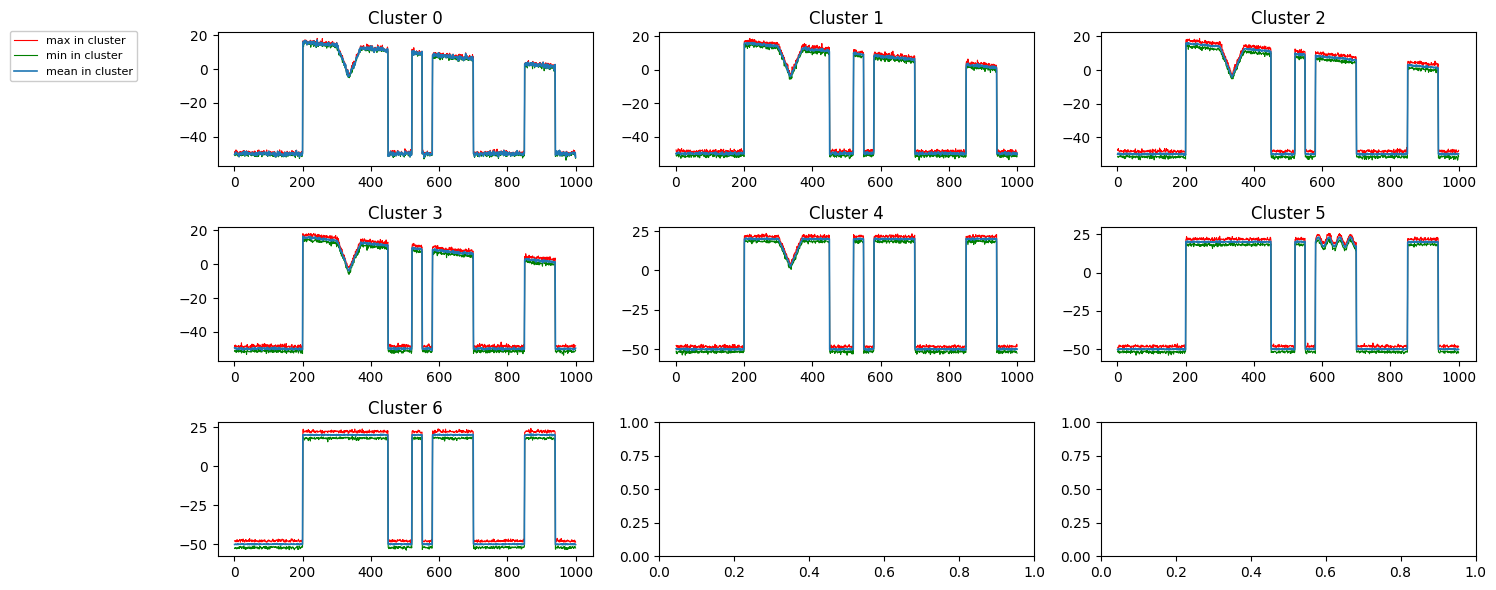

In [161]:
no_rec_clusters = len(recovered_clusterset)
no_cols = 3
no_rows = int(no_rec_clusters / no_cols) + no_rec_clusters % no_cols

fig = plt.figure(figsize=(5 * no_rows, 2 * no_cols))
ax = fig.subplots(no_rows, no_cols)

for i, cluster in enumerate(recovered_clusterset):
    row = int(i / no_cols)
    col = i % no_cols
    cluster_signals = imp_signals[recovered_clusters == cluster,:]
    avg = np.mean(cluster_signals, axis=0)
    mx = np.max(cluster_signals, axis=0)
    mn = np.min(cluster_signals, axis=0)
    ax[row,col].plot(X, mx, color='red', linewidth=0.8, label='max in cluster')
    ax[row,col].plot(X, mn, color='green', linewidth=0.8, label='min in cluster')
    ax[row,col].plot(X, avg, linewidth=1.2, label='mean in cluster')
    ax[row,col].set_title(f"Cluster {i}")
ax[0,0].legend(loc='upper right', fontsize=8, bbox_to_anchor=(-0.2, 1.05), facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

## A cleaner SciPy dendrogram

In [162]:
import idendro
import importlib as imp

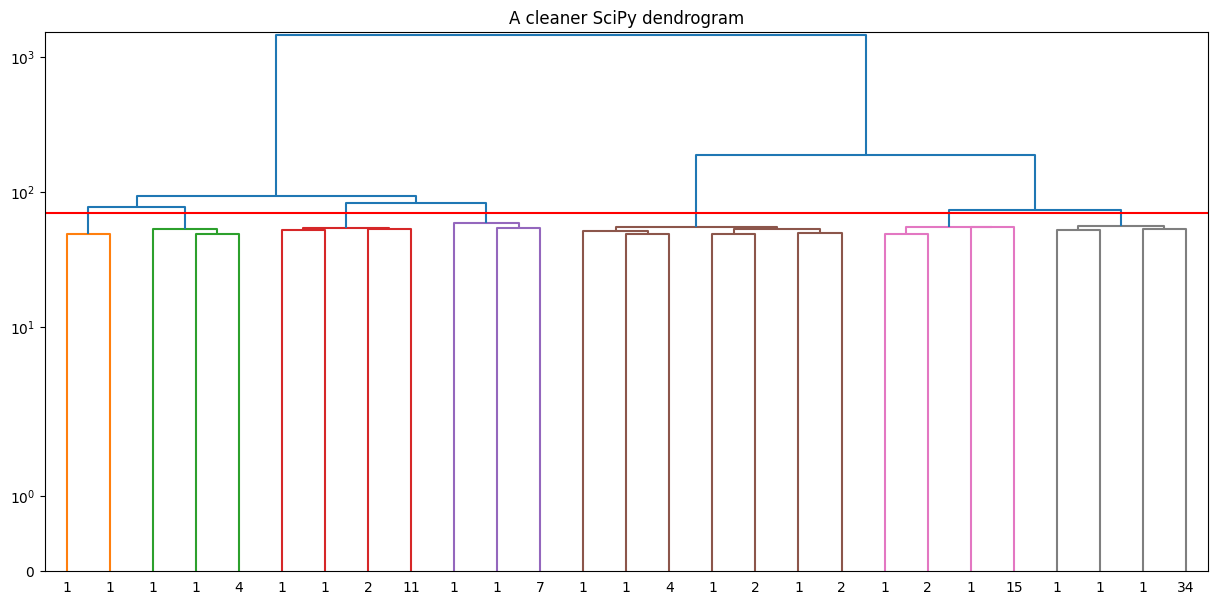

In [164]:
figure = plt.figure(figsize=(15,7))
ax = figure.subplots()
imp.reload(idendro)
dd = idendro.Idendro(model, recovered_clusters, threshold)
sch.dendrogram(
    Z=model, 
    ax=ax, 
    truncate_mode='level', p=4, 
    leaf_label_func= dd.show_counts(),
    color_threshold=threshold,
    orientation='top')
plt.yscale('symlog')
#plt.ylim(top=20)
plt.axhline(threshold, color='red')
plt.title("A cleaner SciPy dendrogram")
plt.xticks(rotation=0)
plt.show()

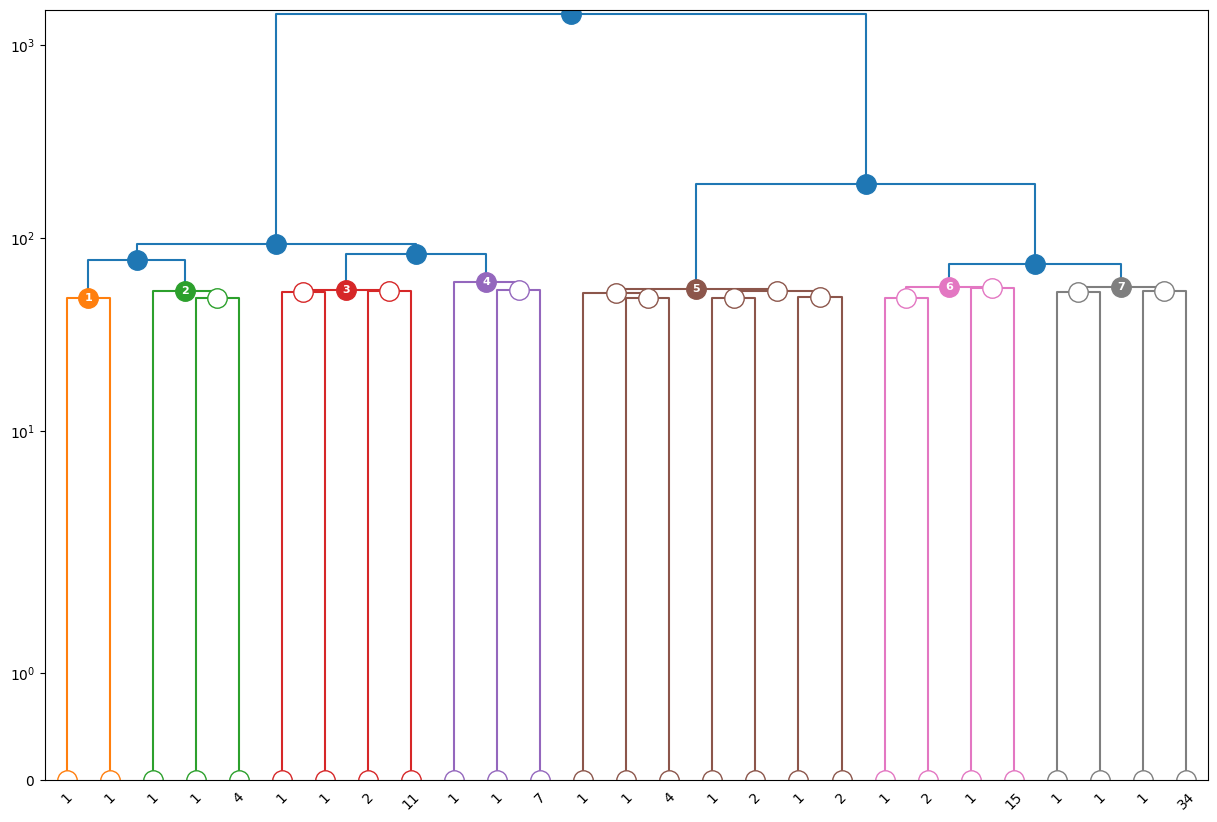

In [200]:
dd = idendro.Idendro(model, recovered_clusters, threshold, dendrogram_kwargs={'leaf_label_func': dd.show_counts()})
fig = plt.figure(figsize=(15,10))
ax = fig.subplots()
dgram = dd.to_scipy(
    orientation='top', 
    show_points = True,
    ax=ax
)
dgram
ax.set_yscale('symlog')

In [213]:
imp.reload(idendro)

dd = idendro.Idendro(model, recovered_clusters, threshold)
dd.dendrogram_kwargs.update({'leaf_label_func': dd.get_counts()})

def hovertext_func(point):
    _, tree = dd.get_tree()

    count = tree[point['id']].get_count()
    if point['type'] in ['cluster', 'supercluster']:
        nodes = tree[point['id']].pre_order(lambda x: x.get_id() if x.is_leaf() else None)  
        sds = imp_signals[nodes, :].std(axis=0) 
        return f"Number of items: {count} <br>" + f"Type: {point['type']} <br>" + f"{sds.max():.2f}"
    else:
        return f"Number of items: {count} <br>" + f"Type: {point['type']}"

pltd = dd.to_plotly(
    orientation='top', 
    show_points = True, 
    width=1000,
    height=800,
    point_trace_kwargs = {'textfont_color': 'blue', 'marker': {'size': 10}},
    point_hover_func= hovertext_func
)
pltd.update_yaxes(type='log', range=(-1, 3.3))
pltd
